In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

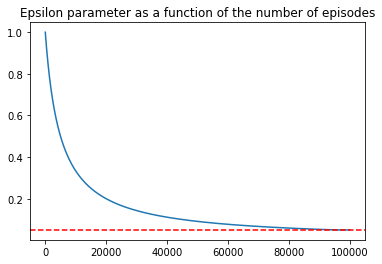

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 22

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -24.26927433627962
Episode: 200. Elapsed time  0.12  minuts. epsilon 0.9617 Discounted reward:  -21.712198978249454
Episode: 300. Elapsed time  0.2  minuts. epsilon 0.9436 Discounted reward:  -22.85638760185186
Episode: 400. Elapsed time  0.28  minuts. epsilon 0.9261 Discounted reward:  -22.18567486635132
Episode: 500. Elapsed time  0.37  minuts. epsilon 0.9093 Discounted reward:  -22.786200089048062
Episode: 600. Elapsed time  0.47  minuts. epsilon 0.893 Discounted reward:  -24.01446936762493
Episode: 700. Elapsed time  0.57  minuts. epsilon 0.8773 Discounted reward:  -24.628852399254438
Episode: 800. Elapsed time  0.68  minuts. epsilon 0.8622 Discounted reward:  -25.658168717752442
Episode: 900. Elapsed time  0.79  minuts. epsilon 0.8476 Discounted reward:  -22.50332490491588
Episode: 1000. Elapsed time  0.91  minuts. epsilon 0.8335 Discounted reward:  -20.136216901751784
Episode: 1100. Elapsed time  1.04  m

Episode: 8500. Elapsed time  19.49  minuts. epsilon 0.3704 Discounted reward:  -16.395542676137218
Episode: 8600. Elapsed time  19.8  minuts. epsilon 0.3677 Discounted reward:  -12.267106418004271
Episode: 8700. Elapsed time  20.19  minuts. epsilon 0.365 Discounted reward:  -9.220348192455308
Episode: 8800. Elapsed time  20.51  minuts. epsilon 0.3623 Discounted reward:  -13.07549417145248
Episode: 8900. Elapsed time  20.89  minuts. epsilon 0.3597 Discounted reward:  -14.2619440353584
Episode: 9000. Elapsed time  21.23  minuts. epsilon 0.3572 Discounted reward:  -17.552556901941866
Episode: 9100. Elapsed time  21.6  minuts. epsilon 0.3546 Discounted reward:  -17.39831975446033
Episode: 9200. Elapsed time  21.9  minuts. epsilon 0.3521 Discounted reward:  -13.442636165824078
Episode: 9300. Elapsed time  22.2  minuts. epsilon 0.3497 Discounted reward:  -15.697855388078025
Episode: 9400. Elapsed time  22.5  minuts. epsilon 0.3472 Discounted reward:  -15.07759245144804
Episode: 9500. Elapsed

Episode: 16800. Elapsed time  49.36  minuts. epsilon 0.2294 Discounted reward:  -10.506813299420333
Episode: 16900. Elapsed time  49.74  minuts. epsilon 0.2283 Discounted reward:  -11.148255630112986
Episode: 17000. Elapsed time  50.09  minuts. epsilon 0.2273 Discounted reward:  -11.451991008448374
Episode: 17100. Elapsed time  50.47  minuts. epsilon 0.2263 Discounted reward:  -12.96952410022052
Episode: 17200. Elapsed time  50.9  minuts. epsilon 0.2252 Discounted reward:  -11.48084277290397
Episode: 17300. Elapsed time  51.26  minuts. epsilon 0.2242 Discounted reward:  -10.682149941431046
Episode: 17400. Elapsed time  51.62  minuts. epsilon 0.2232 Discounted reward:  -12.673503693743399
Episode: 17500. Elapsed time  52.02  minuts. epsilon 0.2222 Discounted reward:  -10.27821906632672
Episode: 17600. Elapsed time  52.41  minuts. epsilon 0.2212 Discounted reward:  -14.376390410028453
Episode: 17700. Elapsed time  52.77  minuts. epsilon 0.2203 Discounted reward:  -16.668385181821442
Epis

Episode: 25100. Elapsed time  82.43  minuts. epsilon 0.1661 Discounted reward:  -10.596241892951218
Episode: 25200. Elapsed time  82.94  minuts. epsilon 0.1656 Discounted reward:  -15.213364295128896
Episode: 25300. Elapsed time  83.33  minuts. epsilon 0.165 Discounted reward:  -9.923925140808075
Episode: 25400. Elapsed time  83.75  minuts. epsilon 0.1645 Discounted reward:  -9.426743025904091
Episode: 25500. Elapsed time  84.19  minuts. epsilon 0.1639 Discounted reward:  -14.590660425534814
Episode: 25600. Elapsed time  84.62  minuts. epsilon 0.1634 Discounted reward:  -10.369717260879732
Episode: 25700. Elapsed time  85.05  minuts. epsilon 0.1629 Discounted reward:  -13.012703928764667
Episode: 25800. Elapsed time  85.47  minuts. epsilon 0.1623 Discounted reward:  -12.078636941467863
Episode: 25900. Elapsed time  85.92  minuts. epsilon 0.1618 Discounted reward:  -9.37721522430706
Episode: 26000. Elapsed time  86.34  minuts. epsilon 0.1613 Discounted reward:  -15.373011742635777
Episo

Episode: 33300. Elapsed time  118.04  minuts. epsilon 0.1306 Discounted reward:  -11.416352514692491
Episode: 33400. Elapsed time  118.45  minuts. epsilon 0.1302 Discounted reward:  -10.835082568630822
Episode: 33500. Elapsed time  118.9  minuts. epsilon 0.1299 Discounted reward:  -14.010437258583622
Episode: 33600. Elapsed time  119.32  minuts. epsilon 0.1295 Discounted reward:  -11.364280417807182
Episode: 33700. Elapsed time  119.84  minuts. epsilon 0.1292 Discounted reward:  -12.37292152573135
Episode: 33800. Elapsed time  120.26  minuts. epsilon 0.1289 Discounted reward:  -12.674198376674738
Episode: 33900. Elapsed time  120.75  minuts. epsilon 0.1285 Discounted reward:  -10.74902842004257
Episode: 34000. Elapsed time  121.16  minuts. epsilon 0.1282 Discounted reward:  -9.00104528453668
Episode: 34100. Elapsed time  121.64  minuts. epsilon 0.1279 Discounted reward:  -8.452331202578312
Episode: 34200. Elapsed time  122.1  minuts. epsilon 0.1276 Discounted reward:  -10.7768112372294

Episode: 41500. Elapsed time  153.86  minuts. epsilon 0.1075 Discounted reward:  -8.94134982937119
Episode: 41600. Elapsed time  154.27  minuts. epsilon 0.1073 Discounted reward:  -10.303021986631965
Episode: 41700. Elapsed time  154.72  minuts. epsilon 0.1071 Discounted reward:  -14.87357833255036
Episode: 41800. Elapsed time  155.16  minuts. epsilon 0.1068 Discounted reward:  -8.482879050087629
Episode: 41900. Elapsed time  155.6  minuts. epsilon 0.1066 Discounted reward:  -13.225044344835572
Episode: 42000. Elapsed time  156.0  minuts. epsilon 0.1064 Discounted reward:  -13.592890184011903
Episode: 42100. Elapsed time  156.43  minuts. epsilon 0.1062 Discounted reward:  -8.428055639947752
Episode: 42200. Elapsed time  156.9  minuts. epsilon 0.1059 Discounted reward:  -14.259789839214598
Episode: 42300. Elapsed time  157.35  minuts. epsilon 0.1057 Discounted reward:  -8.934358848567854
Episode: 42400. Elapsed time  157.8  minuts. epsilon 0.1055 Discounted reward:  -13.330577145955498


Episode: 49700. Elapsed time  190.91  minuts. epsilon 0.0914 Discounted reward:  -10.471958854501649
Episode: 49800. Elapsed time  191.33  minuts. epsilon 0.0912 Discounted reward:  -8.725014197192387
Episode: 49900. Elapsed time  191.76  minuts. epsilon 0.0911 Discounted reward:  -9.50774763702873
Episode: 50000. Elapsed time  192.22  minuts. epsilon 0.0909 Discounted reward:  -8.630125978256952
Episode: 50100. Elapsed time  192.66  minuts. epsilon 0.0907 Discounted reward:  -15.862379635509008
Episode: 50200. Elapsed time  193.07  minuts. epsilon 0.0906 Discounted reward:  -9.185138530169452
Episode: 50300. Elapsed time  193.5  minuts. epsilon 0.0904 Discounted reward:  -13.918423962291133
Episode: 50400. Elapsed time  193.91  minuts. epsilon 0.0903 Discounted reward:  -12.043198755023738
Episode: 50500. Elapsed time  194.34  minuts. epsilon 0.0901 Discounted reward:  -11.51325198637516
Episode: 50600. Elapsed time  194.76  minuts. epsilon 0.0899 Discounted reward:  -10.5738189261099

Episode: 57900. Elapsed time  228.6  minuts. epsilon 0.0795 Discounted reward:  -8.594420055881333
Episode: 58000. Elapsed time  229.11  minuts. epsilon 0.0794 Discounted reward:  -11.283015915195955
Episode: 58100. Elapsed time  229.55  minuts. epsilon 0.0792 Discounted reward:  -7.728017527661819
Episode: 58200. Elapsed time  229.99  minuts. epsilon 0.0791 Discounted reward:  -10.340362887957802
Episode: 58300. Elapsed time  230.41  minuts. epsilon 0.079 Discounted reward:  -8.943259947310755
Episode: 58400. Elapsed time  230.9  minuts. epsilon 0.0789 Discounted reward:  -9.029503342693923
Episode: 58500. Elapsed time  231.45  minuts. epsilon 0.0787 Discounted reward:  -11.388593781530073
Episode: 58600. Elapsed time  231.91  minuts. epsilon 0.0786 Discounted reward:  -11.143662275026895
Episode: 58700. Elapsed time  232.42  minuts. epsilon 0.0785 Discounted reward:  -8.545231238976218
Episode: 58800. Elapsed time  232.85  minuts. epsilon 0.0784 Discounted reward:  -8.024868536169889

Episode: 66100. Elapsed time  266.91  minuts. epsilon 0.0703 Discounted reward:  -10.99627289564867
Episode: 66200. Elapsed time  267.37  minuts. epsilon 0.0702 Discounted reward:  -9.398492160039496
Episode: 66300. Elapsed time  267.82  minuts. epsilon 0.0701 Discounted reward:  -8.741705332479862
Episode: 66400. Elapsed time  268.25  minuts. epsilon 0.07 Discounted reward:  -9.220389596472625
Episode: 66500. Elapsed time  268.68  minuts. epsilon 0.0699 Discounted reward:  -8.917407101859302
Episode: 66600. Elapsed time  269.11  minuts. epsilon 0.0698 Discounted reward:  -7.445284605360648
Episode: 66700. Elapsed time  269.57  minuts. epsilon 0.0697 Discounted reward:  -8.33621668535729
Episode: 66800. Elapsed time  270.02  minuts. epsilon 0.0696 Discounted reward:  -9.515666224769937
Episode: 66900. Elapsed time  270.45  minuts. epsilon 0.0695 Discounted reward:  -10.605040706528372
Episode: 67000. Elapsed time  270.9  minuts. epsilon 0.0694 Discounted reward:  -12.52063606107878
Epi

Episode: 74300. Elapsed time  305.51  minuts. epsilon 0.0631 Discounted reward:  -11.093104128787417
Episode: 74400. Elapsed time  305.94  minuts. epsilon 0.063 Discounted reward:  -7.88605596579674
Episode: 74500. Elapsed time  306.44  minuts. epsilon 0.0629 Discounted reward:  -7.730463162303895
Episode: 74600. Elapsed time  306.94  minuts. epsilon 0.0628 Discounted reward:  -9.529987028515619
Episode: 74700. Elapsed time  307.45  minuts. epsilon 0.0627 Discounted reward:  -10.89620034280221
Episode: 74800. Elapsed time  307.94  minuts. epsilon 0.0627 Discounted reward:  -8.15915428465772
Episode: 74900. Elapsed time  308.44  minuts. epsilon 0.0626 Discounted reward:  -9.80014892457743
Episode: 75000. Elapsed time  308.97  minuts. epsilon 0.0625 Discounted reward:  -7.237621285172168
Episode: 75100. Elapsed time  309.4  minuts. epsilon 0.0624 Discounted reward:  -9.358788660237648
Episode: 75200. Elapsed time  309.86  minuts. epsilon 0.0623 Discounted reward:  -10.755948427903066
Epi

Episode: 82500. Elapsed time  343.94  minuts. epsilon 0.0571 Discounted reward:  -10.056852506029266
Episode: 82600. Elapsed time  344.51  minuts. epsilon 0.0571 Discounted reward:  -13.253241493805655
Episode: 82700. Elapsed time  344.99  minuts. epsilon 0.057 Discounted reward:  -9.79055837592093
Episode: 82800. Elapsed time  345.44  minuts. epsilon 0.0569 Discounted reward:  -10.707536600886137
Episode: 82900. Elapsed time  345.88  minuts. epsilon 0.0569 Discounted reward:  -10.404950309552234
Episode: 83000. Elapsed time  346.36  minuts. epsilon 0.0568 Discounted reward:  -11.027804653787046
Episode: 83100. Elapsed time  346.79  minuts. epsilon 0.0568 Discounted reward:  -9.860861550477953
Episode: 83200. Elapsed time  347.23  minuts. epsilon 0.0567 Discounted reward:  -12.208335175486777
Episode: 83300. Elapsed time  347.76  minuts. epsilon 0.0566 Discounted reward:  -13.60315388677135
Episode: 83400. Elapsed time  348.34  minuts. epsilon 0.0566 Discounted reward:  -9.127057728576

Episode: 90700. Elapsed time  382.94  minuts. epsilon 0.0522 Discounted reward:  -9.671014662519433
Episode: 90800. Elapsed time  383.44  minuts. epsilon 0.0522 Discounted reward:  -10.905566511073596
Episode: 90900. Elapsed time  383.88  minuts. epsilon 0.0521 Discounted reward:  -9.592942693446357
Episode: 91000. Elapsed time  384.44  minuts. epsilon 0.0521 Discounted reward:  -9.279625387535068
Episode: 91100. Elapsed time  384.92  minuts. epsilon 0.052 Discounted reward:  -10.479982177478407
Episode: 91200. Elapsed time  385.36  minuts. epsilon 0.052 Discounted reward:  -8.21237084320158
Episode: 91300. Elapsed time  385.9  minuts. epsilon 0.0519 Discounted reward:  -12.111159492486243
Episode: 91400. Elapsed time  386.35  minuts. epsilon 0.0519 Discounted reward:  -10.496733040046133
Episode: 91500. Elapsed time  386.84  minuts. epsilon 0.0518 Discounted reward:  -11.24171670478818
Episode: 91600. Elapsed time  387.27  minuts. epsilon 0.0518 Discounted reward:  -8.364708369517212


Episode: 99000. Elapsed time  422.83  minuts. epsilon 0.05 Discounted reward:  -11.783082522728376
Episode: 99100. Elapsed time  423.4  minuts. epsilon 0.05 Discounted reward:  -8.805116521063571
Episode: 99200. Elapsed time  423.86  minuts. epsilon 0.05 Discounted reward:  -9.285233363041133
Episode: 99300. Elapsed time  424.34  minuts. epsilon 0.05 Discounted reward:  -10.178779863264337
Episode: 99400. Elapsed time  424.79  minuts. epsilon 0.05 Discounted reward:  -8.111683018620221
Episode: 99500. Elapsed time  425.28  minuts. epsilon 0.05 Discounted reward:  -12.726068382973205
Episode: 99600. Elapsed time  425.76  minuts. epsilon 0.05 Discounted reward:  -11.294182574030257
Episode: 99700. Elapsed time  426.21  minuts. epsilon 0.05 Discounted reward:  -7.775008975115919
Episode: 99800. Elapsed time  426.73  minuts. epsilon 0.05 Discounted reward:  -9.493633452072071
Episode: 99900. Elapsed time  427.27  minuts. epsilon 0.05 Discounted reward:  -9.78713883443221
Episode: 100000. E

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);





Test episode: 1


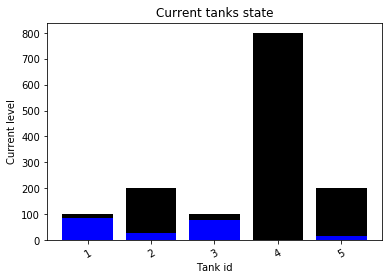

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

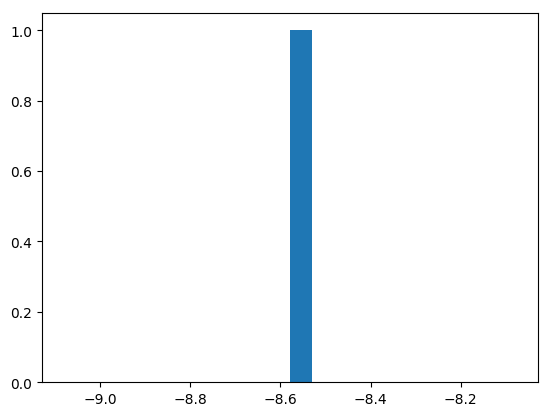

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

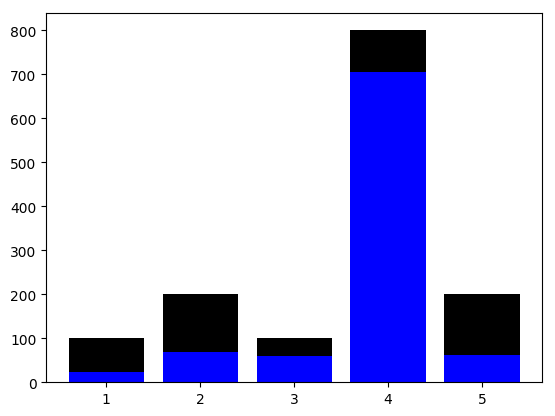

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


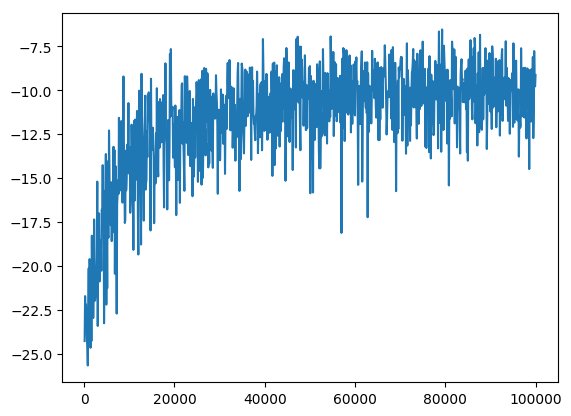

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

26268

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

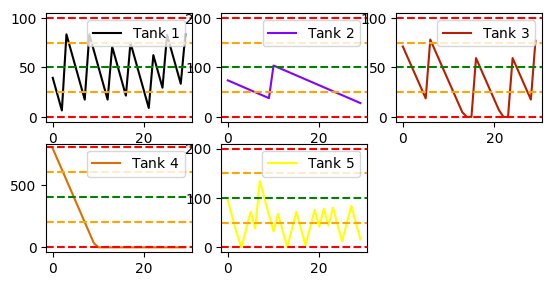

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

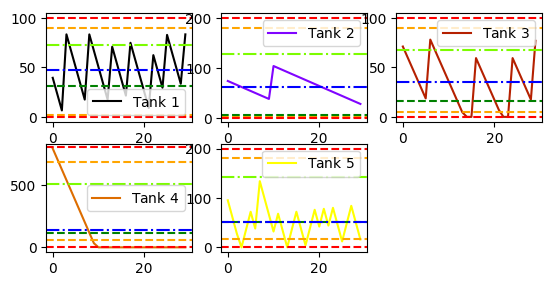

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [22]:
def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.162512 -0.0006827 1.1618293 0300
Episode 1 t 2 -1.6204417 3.16e-05 1.6204733 1400
Episode 1 t 3 -0.563345 2.87e-05 0.5633737 4500
Episode 1 t 4 0.0001636 0.0001636 0.0 5500
Episode 1 t 5 -1.630573 0.0007344 1.6313074 2300
Episode 1 t 6 -0.1155283 3.55e-05 0.1155638 0500
Episode 1 t 7 0.0008252 0.0008252 0.0 5500
Episode 1 t 8 -1.609612 2.72e-05 1.6096392 3400
Episode 1 t 9 0.0005864 0.0005864 0.0 5500
Episode 1 t 10 -1.1618059 2.34e-05 1.1618293 0400
Episode 1 t 11 -1.6095421 9.71e-05 1.6096392 3300
Episode 1 t 12 -1.6312821 2.53e-05 1.6313074 2300
Episode 1 t 13 0.00045 0.00045 0.0 5500
Episode 1 t 14 -1.1611903 0.0006391 1.1618293 0300
Episode 1 t 15 -1.6096097 2.95e-05 1.6096392 3400
Episode 1 t 16 -1.6096185 2.07e-05 1.6096392 4300
Episode 1 t 17 0.0003097 0.0003097 0.0 5500
Episode 1 t 18 -1.2020515 1.88e-05 1.2020703 0200
Episode 1 t 19 -1.6096179 2.13e-05 1.6096392 3300
Episode 1 t 20 0.000741 0.000741

Episode 6 t 22 2.12e-05 2.12e-05 0.0 5500
Episode 6 t 23 -1.6096192 2e-05 1.6096392 4300
Episode 6 t 24 0.0004155 0.0004155 0.0 5500
Episode 6 t 25 -1.161567 0.0002623 1.1618293 0300
Episode 6 t 26 -1.6307751 0.0005323 1.6313074 2400
Episode 6 t 27 -1.6096154 2.38e-05 1.6096392 3300
Episode 6 t 28 -1.6093533 0.0002859 1.6096392 3300
Episode 6 t 29 -1.1618059 2.34e-05 1.1618293 0400
Test episode: 7
Episode 7 t 0 2.47e-05 2.47e-05 0.0 5500
Episode 7 t 1 -1.6096135 2.57e-05 1.6096392 3300
Episode 7 t 2 0.0005759 0.0005759 0.0 5500
Episode 7 t 3 -1.6202316 0.0002417 1.6204733 1400
Episode 7 t 4 -1.1618024 2.69e-05 1.1618293 0300
Episode 7 t 5 2.05e-05 2.05e-05 0.0 5500
Episode 7 t 6 -1.6089008 0.0007384 1.6096392 3300
Episode 7 t 7 -1.6312062 0.0001012 1.6313074 2400
Episode 7 t 8 -1.6089653 0.0006739 1.6096392 3300
Episode 7 t 9 -1.1617972 3.21e-05 1.1618293 0300
Episode 7 t 10 0.0009112 0.0009112 0.0 5500
Episode 7 t 11 -1.6096153 2.39e-05 1.6096392 3400
Episode 7 t 12 0.0005259 0.000525

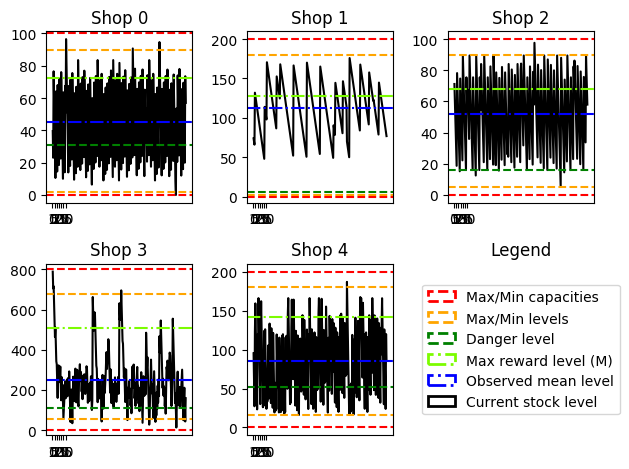

Total discounted rewards Level rewards Transport rewards
-8.655577817099955 -0.09408424925888197 30.366720554999993
Average trucks sent:  41.9


In [23]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.162512 -0.0006827 1.1618293 0300
Episode 1 t 2 -1.6498643 1.59e-05 1.6498802 4200
Episode 1 t 3 0.0006521 0.0006521 0.0 5500
Episode 1 t 4 -0.5632134 0.0001603 0.5633737 4500
Episode 1 t 5 0.0013004 0.0013004 0.0 5500
Episode 1 t 6 -2.6297465 -0.9999868 1.6297597 4100
Episode 1 t 7 -1.1612915 0.0005378 1.1618293 0300
Episode 1 t 8 -1.6096245 1.47e-05 1.6096392 4300
Episode 1 t 9 -1.0454268 0.0008387 1.0462655 5300
Episode 1 t 10 -1.1608471 0.0009823 1.1618293 0400
Episode 1 t 11 -0.5850125 2.94e-05 0.5850419 2500
Episode 1 t 12 -1.6096168 2.24e-05 1.6096392 3400
Episode 1 t 13 0.000246 0.000246 0.0 5500
Episode 1 t 14 -1.1618046 2.48e-05 1.1618293 0300
Episode 1 t 15 1.82e-05 1.82e-05 0.0 5500
Episode 1 t 16 -1.6306795 0.0006279 1.6313074 2300
Episode 1 t 17 -1.6095313 0.0001079 1.6096392 4300
Episode 1 t 18 0.0012301 0.0012301 0.0 5500
Episode 1 t 19 -1.1628249 -0.0009956 1.1618293 0400
Episode 1 t 20 -1.609

Episode 6 t 21 -1.1634665 -0.0016372 1.1618293 0400
Episode 6 t 22 -1.6096168 2.24e-05 1.6096392 3300
Episode 6 t 23 -1.609618 2.12e-05 1.6096392 4300
Episode 6 t 24 -1.6092174 0.0004218 1.6096392 3300
Episode 6 t 25 -0.1155455 1.83e-05 0.1155638 0500
Episode 6 t 26 -0.584114 0.0009279 0.5850419 2500
Episode 6 t 27 -1.609622 1.72e-05 1.6096392 4300
Episode 6 t 28 -1.6084982 0.001141 1.6096392 3300
Episode 6 t 29 -1.6289131 0.0008466 1.6297597 4100
Test episode: 7
Episode 7 t 0 2.47e-05 2.47e-05 0.0 5500
Episode 7 t 1 2.07e-05 2.07e-05 0.0 5500
Episode 7 t 2 -1.6090633 0.0005759 1.6096392 3300
Episode 7 t 3 -0.5631399 0.0002338 0.5633737 4500
Episode 7 t 4 -1.1613105 0.0005188 1.1618293 0300
Episode 7 t 5 -0.5633555 1.82e-05 0.5633737 4500
Episode 7 t 6 -1.0458111 0.0004544 1.0462655 5300
Episode 7 t 7 -1.6093352 0.000304 1.6096392 4300
Episode 7 t 8 -0.5839935 0.0010484 0.5850419 2500
Episode 7 t 9 -1.1630295 -0.0012002 1.1618293 0400
Episode 7 t 10 -1.6096179 2.13e-05 1.6096392 3300
E

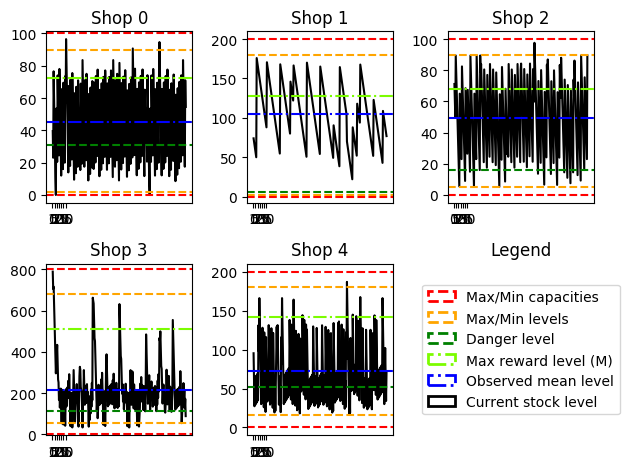

Total discounted rewards Level rewards Transport rewards
-8.221302220282556 -0.1914246914431194 29.90044109699999
Average trucks sent:  41.7


In [24]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.162512 -0.0006827 1.1618293 0300
Episode 1 t 2 -1.6204417 3.16e-05 1.6204733 1400
Episode 1 t 3 2.75e-05 2.75e-05 0.0 5500
Episode 1 t 4 0.0001558 0.0001558 0.0 5500
Episode 1 t 5 -0.5834608 0.0015811 0.5850419 2500
Episode 1 t 6 -1.1617904 3.89e-05 1.1618293 0400
Episode 1 t 7 2.67e-05 2.67e-05 0.0 5500
Episode 1 t 8 9.13e-05 9.13e-05 0.0 5500
Episode 1 t 9 -1.6090546 0.0005846 1.6096392 4300
Episode 1 t 10 -1.161787 4.23e-05 1.1618293 0300
Episode 1 t 11 0.0010502 0.0010502 0.0 5500
Episode 1 t 12 -1.6106775 -0.0010383 1.6096392 4300
Episode 1 t 13 -1.6299491 0.0013583 1.6313074 2300
Episode 1 t 14 -1.1617978 3.15e-05 1.1618293 0400
Episode 1 t 15 -1.046243 2.25e-05 1.0462655 5300
Episode 1 t 16 -1.0461193 0.0001462 1.0462655 5300
Episode 1 t 17 -0.5630711 0.0003027 0.5633737 4500
Episode 1 t 18 -0.3289214 0.001261 0.3301824 0000
Episode 1 t 19 -1.6206643 -0.0110251 1.6096392 4300
Episode 1 t 20 -1.6312674 

Episode 6 t 21 -2.0457334 -0.999468 1.0462655 5400
Episode 6 t 22 -1.1618049 2.44e-05 1.1618293 0300
Episode 6 t 23 -1.04625 1.55e-05 1.0462655 5300
Episode 6 t 24 -1.0454801 0.0007854 1.0462655 5300
Episode 6 t 25 -1.161805 2.43e-05 1.1618293 0400
Episode 6 t 26 -1.6312856 2.18e-05 1.6313074 2300
Episode 6 t 27 -0.5633556 1.81e-05 0.5633737 3500
Episode 6 t 28 -1.0454474 0.0008181 1.0462655 5300
Episode 6 t 29 -1.161804 2.53e-05 1.1618293 0400
Test episode: 7
Episode 7 t 0 -0.5633473 2.64e-05 0.5633737 3500
Episode 7 t 1 2.24e-05 2.24e-05 0.0 5500
Episode 7 t 2 -0.5627994 0.0005744 0.5633737 3500
Episode 7 t 3 -1.6094036 0.0002356 1.6096392 4300
Episode 7 t 4 -0.1150465 0.0005173 0.1155638 0500
Episode 7 t 5 -1.6096192 2e-05 1.6096392 4300
Episode 7 t 6 -1.0458093 0.0004561 1.0462655 5300
Episode 7 t 7 -1.6312107 9.68e-05 1.6313074 2400
Episode 7 t 8 -0.5627077 0.000666 0.5633737 3500
Episode 7 t 9 -1.1618051 2.42e-05 1.1618293 0300
Episode 7 t 10 -1.0456378 0.0006277 1.0462655 5300
E

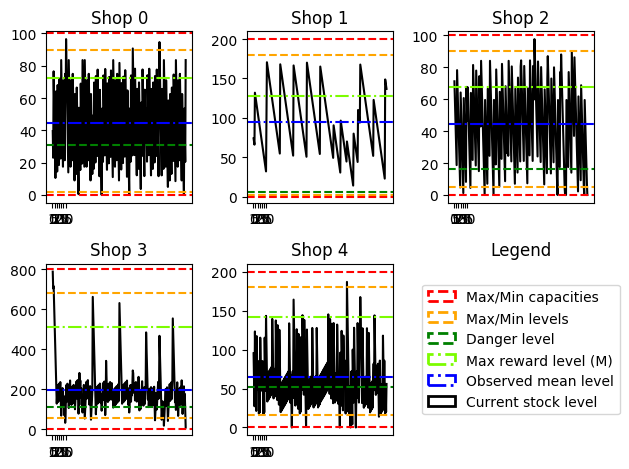

Total discounted rewards Level rewards Transport rewards
-7.93960248193751 -1.6161399313526847 29.14581953999999
Average trucks sent:  39.6


In [25]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 0.001546 0.001546 0.0 5500
Episode 1 t 2 -1.2145973 -0.9999788 0.2146186 5000
Episode 1 t 3 -0.9999759 -0.9999759 0.0 5500
Episode 1 t 4 -0.9999844 -0.9999844 0.0 5500
Episode 1 t 5 -0.9992832 -0.9992832 0.0 5500
Episode 1 t 6 -1.999529 -1.999529 0.0 5500
Episode 1 t 7 -2.0021514 -2.0021514 0.0 5500
Episode 1 t 8 -3.0017075 -3.0017075 0.0 5500
Episode 1 t 9 -3.9999977 -3.9999977 0.0 5500
Episode 1 t 10 -3.999998 -3.999998 0.0 5500
Episode 1 t 11 -3.9999984 -3.9999984 0.0 5500
Episode 1 t 12 -3.9999987 -3.9999987 0.0 5500
Episode 1 t 13 -3.999999 -3.999999 0.0 5500
Episode 1 t 14 -3.9999993 -3.9999993 0.0 5500
Episode 1 t 15 -3.9999997 -3.9999997 0.0 5500
Episode 1 t 16 -3.9999859 -3.9999859 0.0 5500
Episode 1 t 17 -4.0010226 -4.0010226 0.0 5500
Episode 1 t 18 -5.0 -5.0 0.0 5500
Episode 1 t 19 -5.0 -5.0 0.0 5500
Episode 1 t 20 -5.0 -5.0 0.0 5500
Episode 1 t 21 -5.0 -5.0 0.0 5500
Episode 1 t 22 -5.0 -5.0 0.0 5500


Episode 7 t 4 -1.9992025 -1.9992025 0.0 5500
Episode 7 t 5 -2.9999914 -2.9999914 0.0 5500
Episode 7 t 6 -2.9999938 -2.9999938 0.0 5500
Episode 7 t 7 -2.9997804 -2.9997804 0.0 5500
Episode 7 t 8 -3.0015764 -3.0015764 0.0 5500
Episode 7 t 9 -3.9999963 -3.9999963 0.0 5500
Episode 7 t 10 -3.9999967 -3.9999967 0.0 5500
Episode 7 t 11 -3.999997 -3.999997 0.0 5500
Episode 7 t 12 -3.9999973 -3.9999973 0.0 5500
Episode 7 t 13 -3.9999977 -3.9999977 0.0 5500
Episode 7 t 14 -3.999998 -3.999998 0.0 5500
Episode 7 t 15 -3.9999983 -3.9999983 0.0 5500
Episode 7 t 16 -3.9999986 -3.9999986 0.0 5500
Episode 7 t 17 -3.999999 -3.999999 0.0 5500
Episode 7 t 18 -3.9999993 -3.9999993 0.0 5500
Episode 7 t 19 -3.9999996 -3.9999996 0.0 5500
Episode 7 t 20 -4.0 -4.0 0.0 5500
Episode 7 t 21 -3.9991202 -3.9991202 0.0 5500
Episode 7 t 22 -5.0 -5.0 0.0 5500
Episode 7 t 23 -5.0 -5.0 0.0 5500
Episode 7 t 24 -5.0 -5.0 0.0 5500
Episode 7 t 25 -5.0 -5.0 0.0 5500
Episode 7 t 26 -5.0 -5.0 0.0 5500
Episode 7 t 27 -5.0 -5.0 0

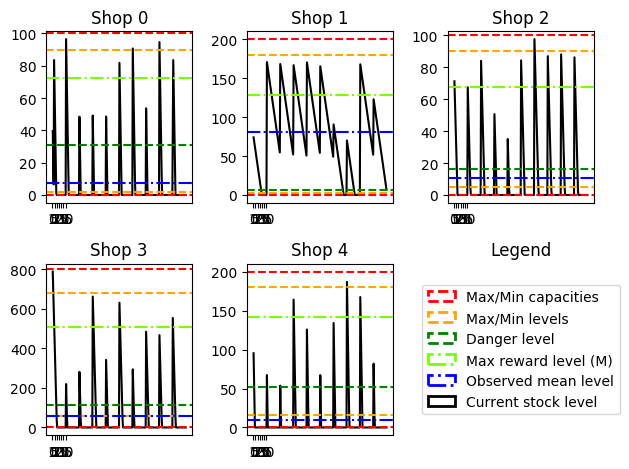

Total discounted rewards Level rewards Transport rewards
-23.949285996508703 -104.84800499316262 0.03301824
Average trucks sent:  0.2


In [26]:
test_simulation(simulation_id= 21, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 0.001546 0.001546 0.0 5500
Episode 1 t 2 -1.2145973 -0.9999788 0.2146186 5000
Episode 1 t 3 -0.5629052 0.0004686 0.5633737 4500
Episode 1 t 4 -0.5633558 1.79e-05 0.5633737 4500
Episode 1 t 5 -0.5846391 0.0004029 0.5850419 2500
Episode 1 t 6 -1.0457753 0.0004902 1.0462655 5400
Episode 1 t 7 -0.2145985 2.01e-05 0.2146186 5000
Episode 1 t 8 -0.0016913 -0.0016913 0.0 5500
Episode 1 t 9 -1.5736356 -0.9994278 0.5742078 1500
Episode 1 t 10 -1.5633616 -0.9999879 0.5633737 4500
Episode 1 t 11 -0.9989554 -0.9989554 0.0 5500
Episode 1 t 12 -2.1165953 -2.0010315 0.1155638 0500
Episode 1 t 13 -2.5629169 -1.9995431 0.5633737 4500
Episode 1 t 14 -2.5633634 -1.9999897 0.5633737 4500
Episode 1 t 15 -1.584311 -0.9992691 0.5850419 2500
Episode 1 t 16 -1.1255433 -1.0099794 0.1155638 0500
Episode 1 t 17 -1.563024 -0.9996503 0.5633737 4500
Episode 1 t 18 -1.563361 -0.9999873 0.5633737 4500
Episode 1 t 19 -0.9995275 -0.9995275 0.0 550

Episode 6 t 17 -1.1165891 -1.0010253 0.1155638 0500
Episode 6 t 18 -1.5633372 -0.9999635 0.5633737 4500
Episode 6 t 19 -1.5840645 -0.9990225 0.5850419 2500
Episode 6 t 20 -1.5628173 -0.9994436 0.5633737 4500
Episode 6 t 21 -1.1146271 -0.9990632 0.1155638 0500
Episode 6 t 22 -1.5633556 -0.9999819 0.5633737 4500
Episode 6 t 23 -0.9991315 -0.9991315 0.0 5500
Episode 6 t 24 -1.5629603 -0.9995866 0.5633737 4500
Episode 6 t 25 -1.114747 -0.9991831 0.1155638 0500
Episode 6 t 26 -1.5628917 -0.9995179 0.5633737 4500
Episode 6 t 27 -1.5842811 -0.9992391 0.5850419 2500
Episode 6 t 28 -1.5630937 -0.99972 0.5633737 4500
Episode 6 t 29 -1.1148563 -0.9992924 0.1155638 0500
Test episode: 7
Episode 7 t 0 -0.5633473 2.64e-05 0.5633737 3500
Episode 7 t 1 2.24e-05 2.24e-05 0.0 5500
Episode 7 t 2 0.0005726 0.0005726 0.0 5500
Episode 7 t 3 -0.5652851 -0.0019114 0.5633737 4500
Episode 7 t 4 -1.1150473 -0.9994835 0.1155638 0500
Episode 7 t 5 -1.5633557 -0.999982 0.5633737 4500
Episode 7 t 6 -0.999547 -0.99954

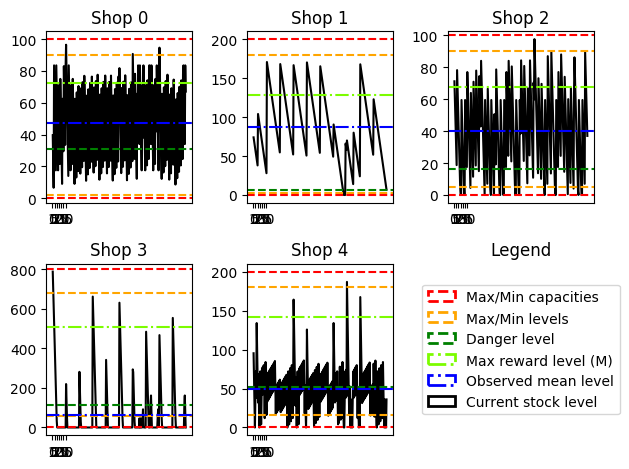

Total discounted rewards Level rewards Transport rewards
-9.393048063334568 -27.754035500463555 12.187806248999998
Average trucks sent:  25.7


In [31]:
test_simulation(simulation_id= 22, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.1618008 2.85e-05 1.1618293 0400
Episode 1 t 2 -0.5741707 3.72e-05 0.5742078 1500
Episode 1 t 3 2.83e-05 2.83e-05 0.0 5500
Episode 1 t 4 -0.5632125 0.0001612 0.5633737 4500
Episode 1 t 5 -1.6305754 0.000732 1.6313074 2300
Episode 1 t 6 -1.1617932 3.62e-05 1.1618293 0400
Episode 1 t 7 3.3e-05 3.3e-05 0.0 5500
Episode 1 t 8 2.07e-05 2.07e-05 0.0 5500
Episode 1 t 9 -0.5627921 0.0005816 0.5633737 3500
Episode 1 t 10 -1.1611976 0.0006318 1.1618293 0300
Episode 1 t 11 -1.6095503 8.89e-05 1.6096392 4300
Episode 1 t 12 -1.6312867 2.07e-05 1.6313074 2400
Episode 1 t 13 -1.6091811 0.0004581 1.6096392 3300
Episode 1 t 14 -1.1617958 3.35e-05 1.1618293 0300
Episode 1 t 15 -1.0462415 2.4e-05 1.0462655 5400
Episode 1 t 16 2.08e-05 2.08e-05 0.0 5500
Episode 1 t 17 -1.609332 0.0003072 1.6096392 3300
Episode 1 t 18 -1.6304317 0.0008757 1.6313074 2300
Episode 1 t 19 -1.161801 2.83e-05 1.1618293 0400
Episode 1 t 20 2.51e-05 2.51e

Episode 6 t 16 0.0006997 0.0006997 0.0 5500
Episode 6 t 17 -1.1618072 2.21e-05 1.1618293 0300
Episode 6 t 18 -1.6096183 2.09e-05 1.6096392 4300
Episode 6 t 19 -1.6312926 1.48e-05 1.6313074 2300
Episode 6 t 20 -1.6199111 0.0005622 1.6204733 1400
Episode 6 t 21 -1.1617932 3.61e-05 1.1618293 0300
Episode 6 t 22 2.49e-05 2.49e-05 0.0 5500
Episode 6 t 23 -1.6096143 2.49e-05 1.6096392 4300
Episode 6 t 24 -1.0458408 0.0004247 1.0462655 5300
Episode 6 t 25 -1.1618037 2.57e-05 1.1618293 0300
Episode 6 t 26 -0.5843528 0.0006892 0.5850419 2500
Episode 6 t 27 -1.6096086 3.06e-05 1.6096392 3400
Episode 6 t 28 -1.6093454 0.0002938 1.6096392 3300
Episode 6 t 29 -0.1155378 2.61e-05 0.1155638 0500
Test episode: 7
Episode 7 t 0 -1.6096095 2.97e-05 1.6096392 3300
Episode 7 t 1 2.57e-05 2.57e-05 0.0 5500
Episode 7 t 2 -1.6090583 0.0005809 1.6096392 3300
Episode 7 t 3 -1.04602 0.0002455 1.0462655 5400
Episode 7 t 4 -1.1617997 2.96e-05 1.1618293 0300
Episode 7 t 5 -1.609606 3.32e-05 1.6096392 4300
Episode 7

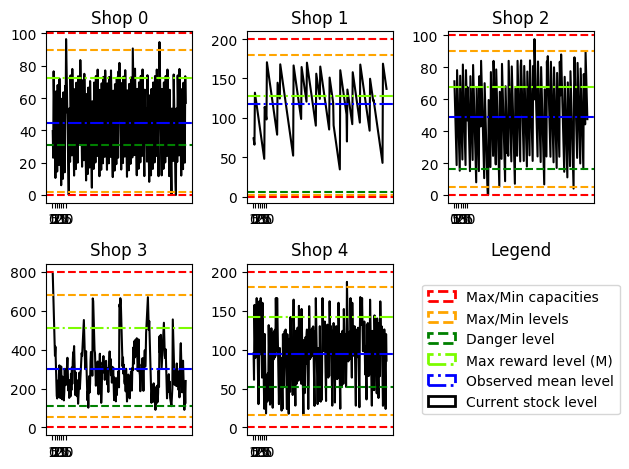

Total discounted rewards Level rewards Transport rewards
-9.142716055705876 -0.49288794015939547 30.526446290999996
Average trucks sent:  42.7


In [27]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.162512 -0.0006827 1.1618293 0300
Episode 1 t 2 -0.5633534 2.03e-05 0.5633737 4500
Episode 1 t 3 -0.5633508 2.29e-05 0.5633737 4500
Episode 1 t 4 -0.5632147 0.000159 0.5633737 4500
Episode 1 t 5 -0.5843154 0.0007265 0.5850419 2500
Episode 1 t 6 -1.1617985 3.09e-05 1.1618293 0300
Episode 1 t 7 0.0005417 0.0005417 0.0 5500
Episode 1 t 8 -1.1618048 2.45e-05 1.1618293 0400
Episode 1 t 9 -0.5633507 2.31e-05 0.5633737 3500
Episode 1 t 10 -1.6297392 2.05e-05 1.6297597 4100
Episode 1 t 11 -1.046181 8.45e-05 1.0462655 5300
Episode 1 t 12 -1.6102039 -0.0005647 1.6096392 4300
Episode 1 t 13 -1.2020476 2.27e-05 1.2020703 0200
Episode 1 t 14 -0.5633536 2.01e-05 0.5633737 3500
Episode 1 t 15 -0.5627774 0.0005963 0.5633737 3500
Episode 1 t 16 -1.6092915 0.0003477 1.6096392 4300
Episode 1 t 17 -1.1612815 0.0005478 1.1618293 0300
Episode 1 t 18 -0.5633502 2.35e-05 0.5633737 4500
Episode 1 t 19 -1.0457836 0.0004819 1.0462655 53

Episode 6 t 15 -1.1618065 2.28e-05 1.1618293 0300
Episode 6 t 16 -0.5633463 2.74e-05 0.5633737 4500
Episode 6 t 17 -1.6204588 1.45e-05 1.6204733 1300
Episode 6 t 18 -1.6090173 0.0006219 1.6096392 3300
Episode 6 t 19 -1.6308241 0.0004833 1.6313074 2400
Episode 6 t 20 -0.1155367 2.71e-05 0.1155638 0500
Episode 6 t 21 -1.6096083 3.09e-05 1.6096392 4300
Episode 6 t 22 -1.6096144 2.48e-05 1.6096392 3300
Episode 6 t 23 -0.5630224 0.0003513 0.5633737 4500
Episode 6 t 24 -1.161801 2.83e-05 1.1618293 0300
Episode 6 t 25 -0.5633466 2.71e-05 0.5633737 4500
Episode 6 t 26 -1.6312832 2.42e-05 1.6313074 2300
Episode 6 t 27 -0.5631562 0.0002175 0.5633737 4500
Episode 6 t 28 -1.6088544 0.0007848 1.6096392 3300
Episode 6 t 29 -1.1618017 2.77e-05 1.1618293 0400
Test episode: 7
Episode 7 t 0 -0.5741853 2.26e-05 0.5742078 1500
Episode 7 t 1 1.97e-05 1.97e-05 0.0 5500
Episode 7 t 2 -1.6096139 2.53e-05 1.6096392 4300
Episode 7 t 3 -1.6094009 0.0002383 1.6096392 3300
Episode 7 t 4 -1.161803 2.63e-05 1.161829

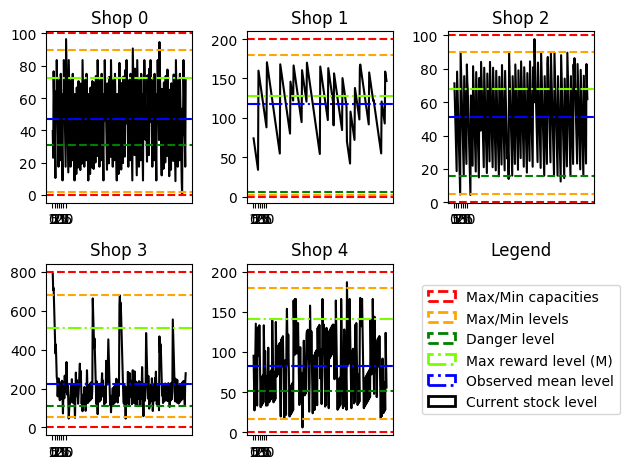

Total discounted rewards Level rewards Transport rewards
-8.3947471030267 -0.09306716403222177 30.284639273999993
Average trucks sent:  43.6


In [28]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -1.162512 -0.0006827 1.1618293 0300
Episode 1 t 2 -0.5633534 2.03e-05 0.5633737 4500
Episode 1 t 3 0.0006497 0.0006497 0.0 5500
Episode 1 t 4 -0.5632225 0.0001512 0.5633737 4500
Episode 1 t 5 -0.5837444 0.0012976 0.5850419 2500
Episode 1 t 6 -1.5633541 -0.9999804 0.5633737 4500
Episode 1 t 7 -0.115024 0.0005399 0.1155638 0500
Episode 1 t 8 -1.6096236 1.56e-05 1.6096392 4300
Episode 1 t 9 -0.5733668 0.000841 0.5742078 1500
Episode 1 t 10 -1.161409 0.0004203 1.1618293 0400
Episode 1 t 11 -1.0461743 9.12e-05 1.0462655 5300
Episode 1 t 12 -1.631288 1.94e-05 1.6313074 2300
Episode 1 t 13 -1.0453903 0.0008752 1.0462655 5300
Episode 1 t 14 -1.1617999 2.94e-05 1.1618293 0400
Episode 1 t 15 -1.0462404 2.51e-05 1.0462655 5300
Episode 1 t 16 -1.0462494 1.61e-05 1.0462655 5300
Episode 1 t 17 0.0008926 0.0008926 0.0 5500
Episode 1 t 18 -1.0444221 0.0018434 1.0462655 5400
Episode 1 t 19 -1.1728548 -0.0110255 1.1618293 0300
Ep

Episode 6 t 18 -1.0462449 2.05e-05 1.0462655 5300
Episode 6 t 19 -0.5850308 1.12e-05 0.5850419 2500
Episode 6 t 20 -1.045184 0.0010815 1.0462655 5300
Episode 6 t 21 -0.7774644 0.0005279 0.7779923 4000
Episode 6 t 22 -1.0457755 0.00049 1.0462655 5300
Episode 6 t 23 -1.6096205 1.87e-05 1.6096392 4300
Episode 6 t 24 -1.0458414 0.0004241 1.0462655 5300
Episode 6 t 25 -0.5628996 0.0004741 0.5633737 4500
Episode 6 t 26 -1.1609856 0.0008437 1.1618293 0300
Episode 6 t 27 -2.6202271 -0.9997538 1.6204733 1400
Episode 6 t 28 -1.6312816 2.58e-05 1.6313074 2300
Episode 6 t 29 -1.0459188 0.0003467 1.0462655 5300
Test episode: 7
Episode 7 t 0 -0.5741853 2.26e-05 0.5742078 1500
Episode 7 t 1 1.97e-05 1.97e-05 0.0 5500
Episode 7 t 2 -1.0456913 0.0005742 1.0462655 5300
Episode 7 t 3 -1.6094027 0.0002365 1.6096392 4300
Episode 7 t 4 -0.1150445 0.0005194 0.1155638 0500
Episode 7 t 5 -1.6096161 2.31e-05 1.6096392 4300
Episode 7 t 6 -1.0458051 0.0004604 1.0462655 5300
Episode 7 t 7 -1.6312053 0.0001021 1.63

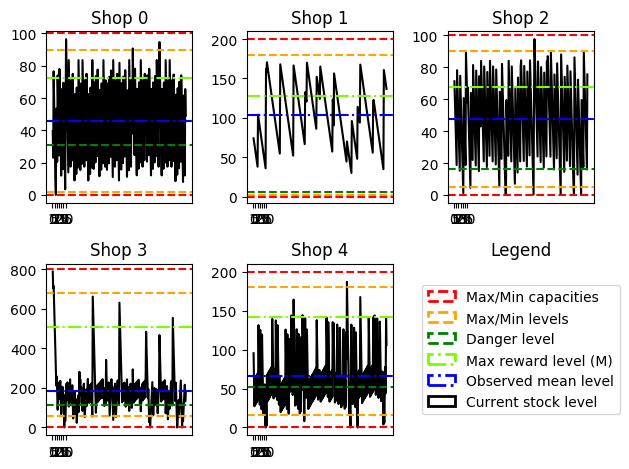

Total discounted rewards Level rewards Transport rewards
-7.939501011509238 -1.4151731385258475 29.495400155999988
Average trucks sent:  39.8


In [29]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes)